# Spurious Regression
By Ehsan Fazel

## Definition

When a regression model appears to find relationships that do not really exist, it is called a spurious regression. (*Davidson. MacKinnon. Econometric Theory and Methods*). Such relationships stem from regressing a non-stationary variable on another non-stationary variable. Upon examination of OLS results, one would find relatively high t-statistics and low p-values for estimated coefficients of the model. In this short notebook, I will examine a spurious regression and comment on the outputs. Below you can find a simulation study. To begin, consider the following linear model:

$$Y_{t} = \alpha + \beta X_{t} + \epsilon_{t}$$

In this model $Y_{t}$ and $X_{t}$ are completely independent. Therefore, estimating above by OLS should result is a close-to-zero $R^2$ and an insignificant coefficient $\beta$. However, if $Y_t$ and $X_t$ are random walks, then t-statistics tend to be large. The fact that could mistakenly be taken for a meaningful causal relationship. The following will present this important issue by an example.

### Spurious Regression: An Example

First, let us import the relevant libraries.

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
import random
%matplotlib inline

To examine a spurious relationship, we need to construct two random walk series, namely $X_t$ and $Y_t$. The following will simulate the data by using NumPy.

In [140]:
# Generate 1000 random steps:
s1 = np.random.standard_normal(1000)
s2 = np.random.standard_normal(1000)
# set the inital values equal to zero
s1[0] = 0
s2[0] = 0
# simulate the data
X = np.cumsum(s1)
Y = np.cumsum(s2)
data = pd.DataFrame({'X': X , 'Y': Y})

Let us plot the time series of $X_t$ and $Y_t$.

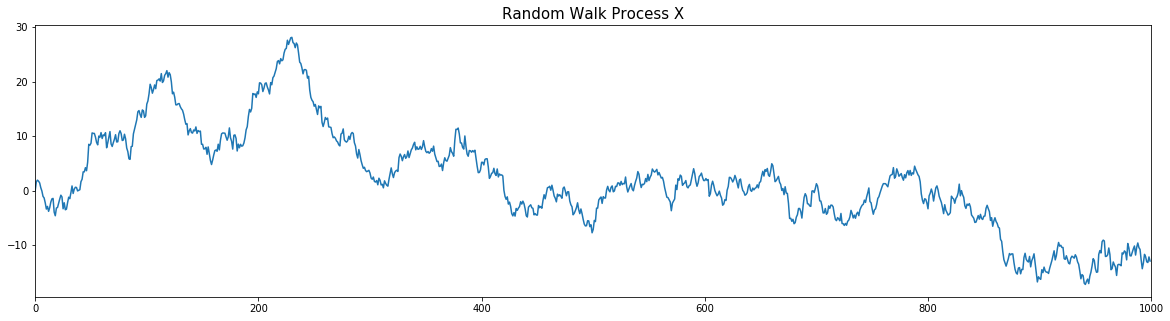

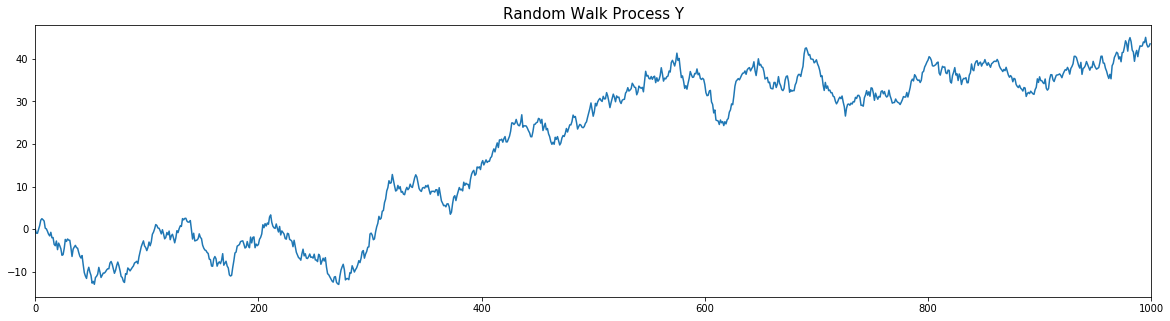

In [141]:
data['X'].plot(figsize = (20,5))
plt.title('Random Walk Process X', size = 15)
ax = plt.gca()
ax.set_xlim([0,1000])
plt.show()
data['Y'].plot(figsize = (20,5))
plt.title('Random Walk Process Y', size = 15)
ax = plt.gca()
ax.set_xlim([0,1000])
plt.show()

As it is evident from the plots, there seem to be upwards and downwards trends present in both series. We can detect non-stationarities in $X_t$ and $Y_t$, but let us ignore these observations and continue with the regression analysis. Below is a simple linear regression estimation done by OLS through statsmodel library.

In [142]:
x = data[['X']]
y = data['Y']
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1201.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):          2.10e-173
Time:                        14:31:55   Log-Likelihood:                -3928.1
No. Observations:                1000   AIC:                             7860.
Df Residuals:                     998   BIC:                             7870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.8412      0.397     54.996      0.0

Despite the fact that two random walk series are independent, the corresponding t-statistics of the coefficient $\beta$ is significant. This can suggest a causal relationship between $X$ and $Y$. However, this is where a spurious relationship can mislead us. Since we know that the series are non-stationary, we can continue the investigation through two channels to question the above results:

1. Investigating the properties of residuals.
2. Adding more variables to the model and investigate its performance.

We start with the first method. If the underlying relationship in the model is indeed true, $\epsilon$ should be white noise. We can check the stationarity of the residuals by running the Dicky-Fuller test. Another method is plotting autocorrelation coefficients. If the series is white noise, then autocorrelation coefficients should be close to zero and remain inside of the confidence bands. 

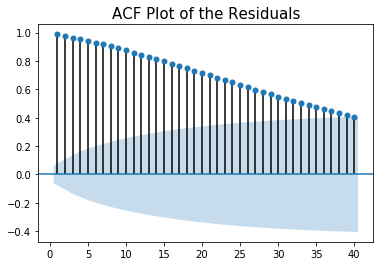

In [143]:
residuals = results.resid
sgt.plot_acf(residuals, lags = 40, zero = False)
plt.title('ACF Plot of the Residuals', size = 15)
plt.show()

The persistent autocorrelations suggest that the residuals are not white noise. Let us perform the Dicky-Fuller test to comment on the stationarity of the process. 

In [144]:
sts.adfuller(residuals)

(-2.561758279188392,
 0.10116140231646126,
 3,
 996,
 {'1%': -3.4369325637409154,
  '5%': -2.8644462162311934,
  '10%': -2.568317409920808},
 3827.6119669675654)

We cannot reject the null hypothesis of non-stationarity. Thus, the residuals are non-stationary and the regression is spurious. 

As was mentioned, another method is including a second explanatory variable into the model. The best candidate is adding $Y$ with one lag along with $X$:

$$Y_t = \alpha + \beta X_{t-1} + \theta Y_{t-1} + \epsilon_{t}$$

In [145]:
x_lag = data.iloc[0:-1]
y = data['Y'][1:]
x_lag = sm.add_constant(x_lag)
model = sm.OLS(list(y), x_lag)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.604e+05
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:32:04   Log-Likelihood:                -1432.5
No. Observations:                 999   AIC:                             2871.
Df Residuals:                     996   BIC:                             2886.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1273      0.066      1.932      0.0

By entering $Y_{t-1}$, the coefficient of X becomes insignificant, whereas the coefficient of $Y_{t-1}$ appears with high t-statistic. This is another diagnostic that the relationship was indeed spurious in the first model. 